In [1]:
!pip install -q jax jaxopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 2.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, hessian, vmap
from jaxopt import LBFGS
from jax.scipy.special import gammaln
from numpy.polynomial.hermite_e import hermegauss
from numpy.linalg import cholesky as np_cholesky, inv as np_inv
from sklearn.base import BaseEstimator
from sklearn.utils.validation import (
    check_array,
    check_is_fitted,
)


def generate_tensor_quadrature_jax(
    d: int,
    n_points: int,
):
    """
    Generate d-dimensional tensor-product Gauss-Hermite
    quadrature nodes and weights for weight exp(-x^2/2).

    Returns:
      xi: jnp.ndarray of shape (N, d)
      wi: jnp.ndarray of shape (N,)
    """
    # Probabilists' Hermite rule uses weight e^{-x^2/2}
    x1d_np, w1d_np = hermegauss(n_points)
    x1d = jnp.array(x1d_np)
    w1d = jnp.array(w1d_np)

    # Create tensor-product grid of nodes
    grids = jnp.meshgrid(
        *([x1d] * d),
        indexing='ij',
    )
    xi = jnp.stack(
        [g.ravel() for g in grids],
        axis=-1,
    )

    # Create product weights
    w_grids = jnp.meshgrid(
        *([w1d] * d),
        indexing='ij',
    )
    wi = jnp.prod(
        jnp.stack(
            [w.ravel() for w in w_grids],
            axis=-1,
        ),
        axis=1,
    )

    return xi, wi


class AGHQBayesGLM(BaseEstimator):
    """
    Adaptive Gauss-Hermite Quadrature for Bayesian GLMs.

    Supports 'gaussian', 'poisson', 'negative_binomial',
    'bernoulli', and 'multinomial'. Uses tensor quadrature
    for posterior mixtures to ensure non-negative weights.
    """

    def __init__(
        self,
        family: str = 'gaussian',
        prior_mean: np.ndarray = None,
        prior_cov: np.ndarray = None,
        n_points: int = 7,
        quad_method: str = 'tensor',
        jitter: float = 1e-6,
        maxiter: int = 500,
        verbose: bool = True,
    ):
        # Set instance variables
        self.family = family
        self.prior_mean = prior_mean
        self.prior_cov = prior_cov
        self.n_points = n_points
        self.quad_method = quad_method
        self.jitter = jitter
        self.maxiter = maxiter
        self.verbose = verbose

    def setup_params(
        self,
        X: np.ndarray,
        y: np.ndarray,
    ):
        """
        Determine parameter dimensions and hyperparameter
        positions. Returns encoded y and total dimension d.
        """
        n, p = X.shape
        if self.family == 'multinomial':
            self.classes_, y_enc = np.unique(
                y,
                return_inverse=True,
            )
            k = self.classes_.size
            d_beta = (p + 1) * (k - 1)
            self.k_ = k
            y = y_enc
        else:
            d_beta = p + 1
            self.k_ = None

        d_hyp = 0
        if self.family == 'gaussian':
            d_hyp = 1
        elif self.family == 'negative_binomial':
            d_hyp = 1

        d = d_beta + d_hyp
        self.d_beta_ = d_beta
        self.pos_sigma2_ = (
            d_beta if self.family == 'gaussian' else None
        )
        self.pos_phi_ = (
            d_beta if self.family == 'negative_binomial' else None
        )
        self.d_hyp_ = d_hyp

        return y, d

    def jax_log_posterior(
        self,
        params: jnp.ndarray,
        X: jnp.ndarray,
        y: jnp.ndarray,
    ) -> jnp.ndarray:
        """
        Compute unnormalized log-posterior including log-
        likelihood, log-prior, and Jacobian terms.
        """
        d_beta = self.d_beta_
        beta = params[:d_beta]

        # Extract hyperparameters
        if self.family == 'gaussian':
            log_sigma2 = params[self.pos_sigma2_]
            sigma2 = jnp.exp(log_sigma2)
        else:
            sigma2 = None

        if self.family == 'negative_binomial':
            log_phi = params[self.pos_phi_]
            phi = jnp.exp(log_phi)
        else:
            phi = None

        # Log-prior for beta ~ N(mean, cov)
        pm = jnp.array(self.prior_mean_[:d_beta])
        pc = jnp.array(self.prior_cov_[:d_beta, :d_beta])
        diff = beta - pm
        lp_beta = -0.5 * diff @ jnp.linalg.solve(pc, diff)
        _, logdet_pc = jnp.linalg.slogdet(pc)
        lp_beta -= 0.5 * (
            d_beta * jnp.log(2 * jnp.pi) + logdet_pc
        )

        # Log-prior for hyperparameters + Jacobians
        lp_hyp = 0.0
        if self.family == 'gaussian':
            mu0 = self.prior_mean_[self.pos_sigma2_]
            s0 = self.prior_cov_[
                self.pos_sigma2_, self.pos_sigma2_
            ]
            d0 = log_sigma2 - mu0
            lp_hyp += -0.5 * (
                d0**2 / s0 + jnp.log(2 * jnp.pi * s0)
            )
            lp_hyp += log_sigma2

        if self.family == 'negative_binomial':
            mu1 = self.prior_mean_[self.pos_phi_]
            s1 = self.prior_cov_[
                self.pos_phi_, self.pos_phi_
            ]
            d1 = log_phi - mu1
            lp_hyp += -0.5 * (
                d1**2 / s1 + jnp.log(2 * jnp.pi * s1)
            )
            lp_hyp += log_phi

        # Log-likelihood
        n = X.shape[0]
        if self.family == 'multinomial':
            k = self.k_
            p = X.shape[1]
            B = beta.reshape(k - 1, p + 1)
            eta_nc = X @ B[:, 1:].T + B[:, 0]
            eta = jnp.concatenate(
                [eta_nc, jnp.zeros((n, 1))],
                axis=1,
            )
            mx = jnp.max(eta, axis=1, keepdims=True)
            logsum = (
                mx + jnp.log(
                    jnp.sum(
                        jnp.exp(eta - mx),
                        axis=1,
                        keepdims=True,
                    )
                )
            )
            ll = jnp.sum(
                eta[jnp.arange(n), y] - logsum.squeeze()
            )
        else:
            eta = X @ beta[1:] + beta[0]
            eta = jnp.clip(eta, -20.0, 20.0)
            if self.family == 'gaussian':
                resid = y - eta
                ll = (
                    -0.5 * jnp.sum(resid**2) / sigma2
                    - 0.5 * n * jnp.log(
                        2 * jnp.pi * sigma2
                    )
                )
            elif self.family == 'poisson':
                mu = jnp.exp(eta)
                ll = jnp.sum(
                    y * eta - mu - gammaln(y + 1)
                )
            elif self.family == 'negative_binomial':
                mu = jnp.exp(eta)
                r = 1.0 / phi
                p_nb = r / (r + mu)
                ll = jnp.sum(
                    gammaln(y + r)
                    - gammaln(r)
                    - gammaln(y + 1)
                    + r * jnp.log(p_nb)
                    + y * jnp.log(1 - p_nb)
                )
            elif self.family == 'bernoulli':
                p_ = jax.nn.sigmoid(eta)
                p_ = jnp.clip(p_, 1e-9, 1 - 1e-9)
                ll = jnp.sum(
                    y * jnp.log(p_)
                    + (1 - y) * jnp.log(1 - p_)
                )
            else:
                raise ValueError(
                    f"Unsupported family '{self.family}'"
                )

        return lp_beta + lp_hyp + ll

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
    ):
        """
        Fit model via AGHQ and store mixture nodes and weights.
        """
        if self.verbose:
            print("Validating data and setting up parameters...")
        X = check_array(X)
        y, d = self.setup_params(X, y)
        self._X, self._y = X, y

        if self.verbose:
            print("Initializing priors...")
        if self.prior_mean is None:
            pm = np.zeros(d)
            if self.family == 'gaussian':
                pm[self.pos_sigma2_] = np.log(np.var(y))
            elif self.family == 'negative_binomial':
                pm[self.pos_phi_] = 0.0
        else:
            pm = np.array(self.prior_mean, float)
        if self.prior_cov is None:
            pc = np.eye(d) * 10.0
        else:
            pc = np.array(self.prior_cov, float)
        self.prior_mean_, self.prior_cov_ = pm, pc

        if self.verbose:
            print("Finding posterior mode via LBFGS...")
        X_jax = jnp.array(X)
        y_jax = jnp.array(y)
        f_jax = jit(
            lambda th: self.jax_log_posterior(
                th,
                X_jax,
                y_jax,
            )
        )
        hess_jax = jit(hessian(f_jax))
        init = jnp.array(pm)
        solver = LBFGS(
            fun=lambda th: -f_jax(th),
            maxiter=self.maxiter,
        )
        sol = solver.run(init)
        theta_mode = sol.params

        if self.verbose:
            print("Computing Hessian and covariance at mode...")
        H_raw = np.array(hess_jax(theta_mode))
        H_neg = -0.5 * (H_raw + H_raw.T)
        jitter = self.jitter
        for _ in range(5):
            try:
                _ = np_cholesky(H_neg)
                break
            except np.linalg.LinAlgError:
                H_neg += np.eye(d) * jitter
                jitter *= 10
        cov = np_inv(H_neg)
        cov_jnp = jnp.array(cov)
        L = jnp.linalg.cholesky(cov_jnp)
        log_detL = 0.5 * jnp.linalg.slogdet(cov_jnp)[1]

        if self.verbose:
            print("Generating quadrature nodes and weights...")
        if self.quad_method != 'tensor':
            raise NotImplementedError(
                "Only tensor quadrature supported"
            )
        xi, wi = generate_tensor_quadrature_jax(
            d,
            self.n_points,
        )

        if self.verbose:
            print("Evaluating log-posterior at quadrature nodes...")
        thetas = theta_mode[None, :] + xi @ L.T
        logp = vmap(f_jax)(thetas)

        # Weight correction for probabilists' Hermite
        log_wcorr = jnp.log(wi) + 0.5 * jnp.sum(
            xi**2,
            axis=1,
        )

        logw = logp + log_wcorr + log_detL
        maxlw = jnp.max(logw)
        w = jnp.exp(logw - maxlw)
        w_norm = w / jnp.sum(w)

        self.theta_nodes_ = np.array(thetas)
        self.W_ = np.array(w_norm)
        self.log_marginal_ = float(
            jnp.log(jnp.sum(w)) + maxlw
        )
        self.mode_ = np.array(theta_mode)
        self.cov_ = cov
        self.n_features_in_ = X.shape[1]

        if self.verbose:
            print("Fitting complete.")
        return self

    def posterior_mean(
        self,
    ) -> np.ndarray:
        """Posterior mean of parameters via mixture."""
        check_is_fitted(
            self,
            ['theta_nodes_', 'W_'],
        )
        return self.theta_nodes_.T @ self.W_

    def posterior_covariance(
        self,
    ) -> np.ndarray:
        """Posterior covariance of parameters via mixture."""
        check_is_fitted(
            self,
            ['theta_nodes_', 'W_'],
        )
        m = self.posterior_mean()
        diffs = self.theta_nodes_ - m[None, :]
        return diffs.T @ (diffs * self.W_[:, None])

    def predict(
        self,
        X: np.ndarray,
    ) -> np.ndarray:
        """Predict posterior mean responses or labels."""
        check_is_fitted(self, ['theta_nodes_', 'W_'])
        X = check_array(X)

        # Classification families
        if self.family in ('bernoulli', 'multinomial'):
            return self.predict_proba(X).argmax(axis=1)

        # Regression families: compute mixture mean of response
        beta_nodes = self.theta_nodes_[:, :self.d_beta_]
        eta_nodes = beta_nodes[:, 1:] @ X.T + beta_nodes[:, 0][:, None]
        if self.family == 'gaussian':
            mu_nodes = eta_nodes
        else:
            mu_nodes = np.exp(eta_nodes)
        preds = (self.W_[:, None] * mu_nodes).sum(axis=0)
        return preds

    def predict_proba(
        self,
        X: np.ndarray,
    ) -> np.ndarray:
        """Predict class probabilities via mixture of logits."""
        check_is_fitted(self, ['theta_nodes_', 'W_'])
        X = check_array(X)

        if self.family == 'bernoulli':
            beta_nodes = self.theta_nodes_[:, :self.d_beta_]
            eta_nodes = beta_nodes[:, 1:] @ X.T + beta_nodes[:, 0][:, None]
            p_nodes = 1 / (1 + np.exp(-eta_nodes))
            p_mean = p_nodes.T @ self.W_
            return np.vstack([1 - p_mean, p_mean]).T

        if self.family == 'multinomial':
            N, d = self.theta_nodes_.shape
            p = X.shape[1]
            k = self.k_
            beta_nodes = self.theta_nodes_[:, :self.d_beta_]
            beta_nodes = beta_nodes.reshape(N, k - 1, p + 1)
            eta_nc = beta_nodes[:, :, 1:] @ X.T + beta_nodes[:, :, 0][:, :, None]
            zeros = np.zeros((N, 1, X.shape[0]))
            eta = np.concatenate([eta_nc, zeros], axis=1)
            mx = np.max(eta, axis=1, keepdims=True)
            exp_e = np.exp(eta - mx)
            probs_nodes = exp_e / exp_e.sum(axis=1, keepdims=True)
            probs = np.tensordot(
                self.W_, probs_nodes,axes=(0,0)
            ).T
            return probs

        raise AttributeError(
            "predict_proba only valid for classification families"
        )

    def predict_intervals(
        self,
        X: np.ndarray,
        alpha: float = 0.05,
    ) -> np.ndarray:
        """Approximate prediction intervals by inverting
        the mixture CDF for regression families."""
        import scipy.stats as stats
        from scipy.optimize import bisect

        check_is_fitted(self, ['theta_nodes_', 'W_'])
        X = check_array(X)
        n = X.shape[0]
        lower = np.empty(n)
        upper = np.empty(n)
        pm = self.posterior_mean()

        for i, xi in enumerate(X):
            def mix_cdf(y):
                tot = 0.0
                for th, wj in zip(self.theta_nodes_, self.W_):
                    b = th[:self.d_beta_]
                    mu_pred = xi @ b[1:] + b[0]
                    if self.family == 'gaussian':
                        log_sigma2 = th[self.pos_sigma2_]
                        sigma2 = np.exp(log_sigma2)
                        tot += wj * stats.norm(
                            loc=mu_pred,
                            scale=np.sqrt(sigma2),
                        ).cdf(y)
                    elif self.family == 'poisson':
                        lam = np.exp(mu_pred)
                        tot += wj * stats.poisson(
                            mu=lam,
                        ).cdf(y)
                    elif self.family == 'negative_binomial':
                        log_phi = th[self.pos_phi_]
                        phi = np.exp(log_phi)
                        r = 1.0 / phi
                        p_nb = r / (r + np.exp(mu_pred))
                        tot += wj * stats.nbinom(
                            r,
                            p_nb,
                        ).cdf(y)
                    else:
                        raise ValueError(
                            "predict_intervals only for gaussian,"
                            "poisson, or negative_binomial"
                        )
                return tot

            if self.family == 'gaussian':
                mu_i = xi @ pm[1:] + pm[0]
                sd_i = np.sqrt(np.exp(pm[self.pos_sigma2_]))
                lo, hi = mu_i - 5 * sd_i, mu_i + 5 * sd_i
            else:
                lo, hi = 0.0, np.max(self._y) * 3.0
            t_lo, t_hi = alpha / 2, 1 - alpha / 2
            while mix_cdf(lo) > t_lo:
                lo -= (hi - lo) or 1.0
            while mix_cdf(hi) < t_hi:
                hi += (hi - lo) or 1.0
            lower[i] = bisect(
                lambda y: mix_cdf(y) - t_lo,
                lo,
                hi,
            )
            upper[i] = bisect(
                lambda y: mix_cdf(y) - t_hi,
                lo,
                hi,
            )

        return np.vstack([lower, upper]).T

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the 'warpbreaks' dataset
rds = sm.datasets.get_rdataset("warpbreaks", "datasets")
data = rds.data.copy()

Validating data and setting up parameters...
Initializing priors...
Finding posterior mode via LBFGS...
Computing Hessian and covariance at mode...
Generating quadrature nodes and weights...
Evaluating log-posterior at quadrature nodes...
Fitting complete.

Test RMSE: 9.860



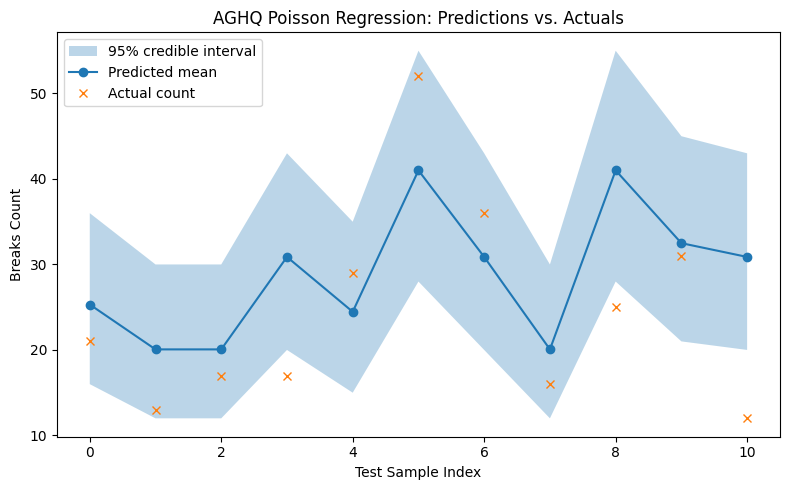

In [4]:
# Prepare design matrix X and response y
en = OneHotEncoder(drop='first', sparse_output=False)
cat = data[['wool', 'tension']]
X_cat = en.fit_transform(cat)
X = np.hstack([np.ones((data.shape[0], 1)), X_cat])
y = data['breaks'].to_numpy()

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit Bayesian Poisson regression via AGHQ on training data
dmodel = AGHQBayesGLM(
    family='poisson',
    n_points=5,
    quad_method='tensor'
)
model = dmodel.fit(X_train, y_train)

# Predict on test set: mean and 95% credible intervals
mu_test = model.predict(X_test)
ci_test = model.predict_intervals(X_test)

# Compute RMSE between posterior mean and actual counts
rmse = np.sqrt(mean_squared_error(y_test, mu_test))
print(f"\nTest RMSE: {rmse:.3f}\n")

# Plot results: actual vs. predicted mean, with credible bands
plt.figure(figsize=(8, 5))
idx = np.arange(len(y_test))
lower, upper = ci_test[:, 0], ci_test[:, 1]

# Plot credible interval as shaded area
plt.fill_between(
    idx,
    lower,
    upper,
    alpha=0.3,
    label='95% credible interval'
)

# Plot posterior mean
plt.plot(idx, mu_test, 'o-', label='Predicted mean')

# Plot actual counts
plt.plot(idx, y_test, 'x', label='Actual count')

plt.xlabel('Test Sample Index')
plt.ylabel('Breaks Count')
plt.title('AGHQ Poisson Regression: Predictions vs. Actuals')
plt.legend()
plt.tight_layout()
plt.show()